### Installations & Imports to work in VSCode

In [1]:
# Установка версий программных пакетов
!pip install -r ../requirements.txt -q

В результате проверки результатов обучения моделей разными участниками было выявлено их расхождение при тождественности параметров. Такое несоответствие [происходит](https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras) вследствие использования библиотеками Numpy и TensorFlow случайных чисел в генераторах псевдослучайных значений. Для воспроизодимости результатов обучения в VS Code зафиксируем seed,- начальное значение генератора псевдослучайных чисел.

In [2]:
# Импортируем библиотеки
import mne
import numpy as np
import pandas as pd
import pickle
from zipfile import ZipFile


# графические библиотеки
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#%matplotlib widget
import os

# Зафиксируем PYTHONHASHSEED для воспроиизводимости результатов обучения модели
seed_value = 0
os.environ['PYTHONHASHSEED'] = str(seed_value)

# Логгирование процесса
from comet_ml import Experiment

# библиотеки машинного обучения
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import layers

import random

# библиотека взаимодействия с интерпретатором
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


# Скрытие хода обучения модели,который загромождает ноутбук
from IPython.display import clear_output

In [3]:
# Библиотека вызова функций, специально разработанных для данного ноутбука
sys.path.insert(1, '/gesture_classification/')
from utils import functions as f
from utils import figures 
#from utils import credentials as cr

In [4]:
# Данные (api_key) для доступа к comet.ml будем импортировать из json файла
import json
with open("/gesture_classification/utils/credentials.json", "r") as j:
    keys = json.load(j)
clear_output(wait=False)

In [5]:
experiment = Experiment(
    api_key = keys['api_key'],
    project_name ='gesture-classification',
    workspace ='alex1iv',
);

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/alex1iv/gesture-classification/c91d260ad3bc408484bb872a827de41e



In [6]:
# константы и глобальные параметры данных
# Все исходные файлы размещены в папке data
PATH = '/gesture_classification/data/'

# Папка для сохранения весов лучшей модели при обучении (исп-ся в ModelCheckpoint в функции callbacks)
PATH_TEMP_MODEL = '/gesture_classification/models/temp_best_model'

if not os.path.exists(PATH_TEMP_MODEL):
    os.mkdir(PATH_TEMP_MODEL)    

# Папка для сохранения обученных моделей для последующего предсказания
PATH_FOR_MODEL = '/gesture_classification/models'

if not os.path.exists(PATH_FOR_MODEL):
    os.mkdir(PATH_FOR_MODEL) 

In [7]:
# 1. Установим начальное значение для генератора случайных чисел в Python
random.seed(seed_value)

# 2. Установим начальное значение для генератора случайных чисел в Numpy
np.random.seed(seed_value)

# 3. Установим начальное значение для генератора случайных чисел в tensorflow 
tf.random.set_seed(seed_value)

# 4. Конфигурация Tenzorflow
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [8]:
# Проверим воспроизводимость результата случайного распределения 
model = keras.Sequential( [ 
layers.Dense(2,name = 'one'),
layers.Dense(3,activation = 'sigmoid', name = 'two'),
layers.Dense(2,name = 'three')])

x = tf.random.uniform((12,12))
print(model(x))

print()

tf.Tensor(
[[ 0.84417915 -0.09455603]
 [ 0.6749006  -0.13408634]
 [ 0.68973166 -0.14211544]
 [ 0.71698654 -0.13607895]
 [ 0.68233585 -0.15881413]
 [ 0.6576998  -0.15178624]
 [ 0.703879   -0.13622592]
 [ 0.7794712  -0.12639348]
 [ 0.8378607  -0.11526634]
 [ 0.7633468  -0.1148871 ]
 [ 0.8343782  -0.09699636]
 [ 0.79229456 -0.12571578]], shape=(12, 2), dtype=float32)



Результат вычислений должен совпадать:
```
tf.Tensor(
[[ 0.84417915 -0.09455603]
 [ 0.6749006  -0.13408634]
 [ 0.68973166 -0.14211544]
 [ 0.71698654 -0.13607895]
 [ 0.68233585 -0.15881413]
 [ 0.6576998  -0.15178624]
 [ 0.703879   -0.13622592]
 [ 0.7794712  -0.12639348]
 [ 0.8378607  -0.11526634]
 [ 0.7633468  -0.1148871 ]
 [ 0.8343782  -0.09699636]
 [ 0.79229456 -0.12571578]], shape=(12, 2), dtype=float32)

```

### Read Data

In [9]:
# Словарь для последующей агрегации данных. Изначально прописаны названия файлов в архиве
mounts = {
    1 : {
        'path_X_train' : 'X_train_1.npy',
        'path_y_train' : 'y_train_1.npy',
        'path_X_test_dataset' : 'X_test_dataset_1.pkl',
    },
    2 : {
        'path_X_train' : 'X_train_2.npy',
        'path_y_train' : 'y_train_2.npy',
        'path_X_test_dataset' : 'X_test_dataset_2.pkl',
    },
    3 : {
        'path_X_train' : 'X_train_3.npy',
        'path_y_train' : 'y_train_3.npy',
        'path_X_test_dataset' : 'X_test_dataset_3.pkl',
    }
}

In [10]:
# Чтение данных из архива (без распаковки архива)
path_to_zip = os.path.join(PATH, 'motorica-advanced-gesture-classification.zip')

for mount_name, mount in mounts.items():
    mount['X_train'] = np.load(path_to_zip)[mount['path_X_train']]
    mount['y_train'] = np.load(path_to_zip)[mount['path_y_train']]
    
    with ZipFile(path_to_zip) as myzip:
        with myzip.open(mount['path_X_test_dataset']) as myfile:
            mount['X_test_dataset'] = pickle.load(myfile)
    print(f"Количество наблюдений пилота {mount_name}: {len(mount['X_test_dataset'])}")
    

Количество наблюдений пилота 1: 899
Количество наблюдений пилота 2: 855
Количество наблюдений пилота 3: 861


In [11]:
# Чтение sample_submission.csv из архива (без распаковки архива)
with ZipFile(path_to_zip) as myzip:
    y_test = pd.read_csv(myzip.open('sample_submission.csv'))

y_test[['subject_id', 'sample', 'timestep']] = (
    y_test['subject_id-sample-timestep']
    .str.split('-', 2, expand=True)
    .astype(int)
)
#y_test

print(f"размерность y_test {y_test.shape}")
display(y_test.head())
# y_test.set_index(['subject_id', 'sample'])

y_test.groupby(['subject_id'])['sample'].nunique()

размерность y_test (471610, 5)


,subject_id-sample-timestep,class,subject_id,sample,timestep
0,1-0-0,4,1,0,0
1,1-0-1,2,1,0,1
2,1-0-2,0,1,0,2
3,1-0-3,0,1,0,3
4,1-0-4,3,1,0,4


subject_id
1    899
2    855
3    861
Name: sample, dtype: int64

Отобразим тренировочные данные: показания датчиков и классы жестов.

Логгируем исходные данные


{'web': 'https://www.comet.com/api/image/download?imageId=6cc647d014f548d6bacd205578acab72&experimentKey=c91d260ad3bc408484bb872a827de41e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=6cc647d014f548d6bacd205578acab72&experimentKey=c91d260ad3bc408484bb872a827de41e',
 'imageId': '6cc647d014f548d6bacd205578acab72'}

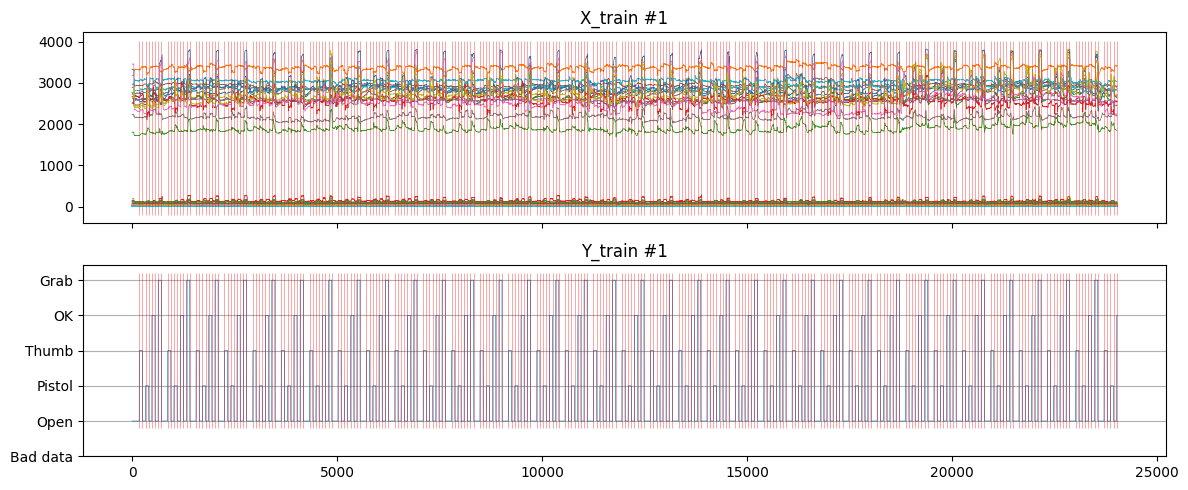

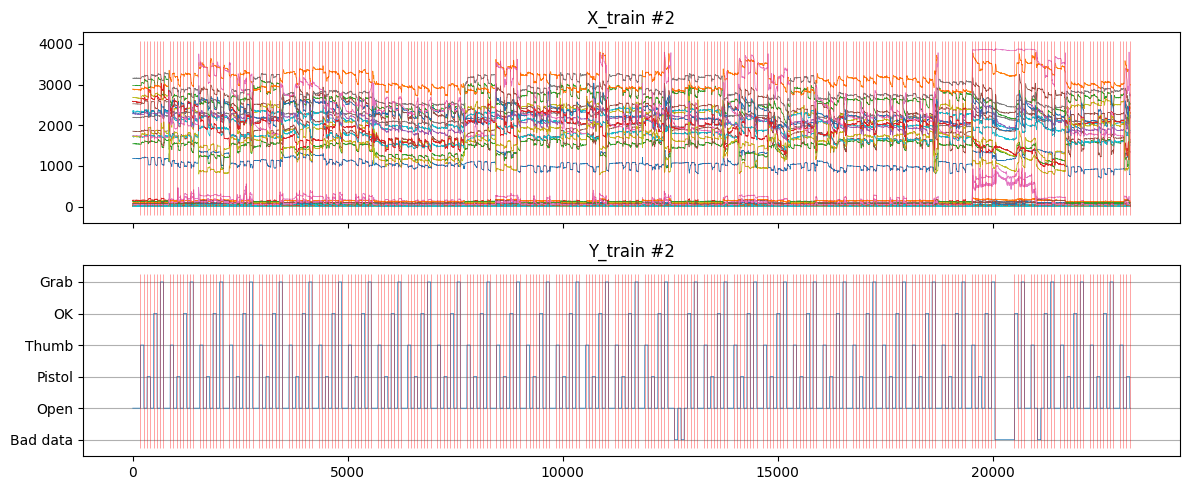

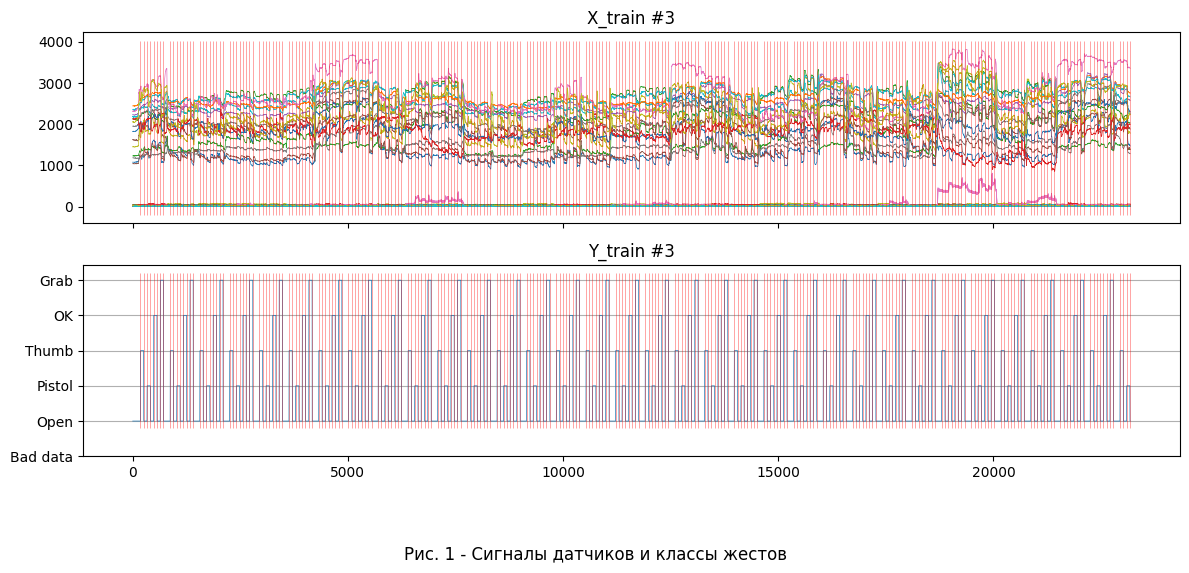

In [13]:
figures.get_display_data(mounts=mounts, plot_counter=1)
print('Логгируем исходные данные')
experiment.log_figure(figure_name='fig.1') # логгируем график #figure=fig
#plt.show() 

### Data preparations for Neural Networks

In [14]:
SFREQ = 1000.0 / 33

for mount_name, mount in mounts.items():
    X_train = mount['X_train'] 
    y_train = mount['y_train']
    
    raw = mne.io.RawArray(
        data=X_train.T,
        info=mne.create_info(
            ch_names=list(np.arange(X_train.shape[1]).astype(str)),
            sfreq=SFREQ,
            ch_types='eeg'
        )
    )
    raw_y = mne.io.RawArray(
        data=y_train.reshape(1,-1),
        info=mne.create_info(
            ch_names=['y'],
            sfreq=SFREQ,
            ch_types='misc'
        )
    )
    raw = raw.add_channels([raw_y])
    
    mount['raw'] = raw

Creating RawArray with float64 data, n_channels=50, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=24030
    Range : 0 ... 24029 =      0.000 ...   792.957 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23202
    Range : 0 ... 23201 =      0.000 ...   765.633 secs
Ready.
Creating RawArray with float64 data, n_channels=50, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.
Creating RawArray with float64 data, n_channels=1, n_times=23177
    Range : 0 ... 23176 =      0.000 ...   764.808 secs
Ready.


In [15]:
for mount_name, mount in mounts.items():
    raw = mount['raw']
    y_train = mount['y_train']

    # выбор индексов, где происходит изменение жеста    
    events = np.where(np.abs(np.diff(y_train)) > 0)[0]

    events = np.stack([
        events,
        np.zeros_like(events),
        np.zeros_like(events)
    ], axis=1)
    
    
    epochs = mne.Epochs(
        raw,
        events=events,
        tmin=-1, 
        tmax=1*2.5, 
        preload=True,
        baseline=None,
        picks='all'
    )
    
    X_train_nn = epochs.copy().pick_types(eeg =True)._data.swapaxes(1, 2)
    y_train_nn = epochs.copy().pick_types(misc=True)._data.swapaxes(1, 2)
    y_train_nn = tf.keras.utils.to_categorical(y_train_nn)
    
    mount['X_train_nn'] = X_train_nn
    mount['y_train_nn'] = y_train_nn

    print(X_train_nn.shape, y_train_nn.shape)

Not setting metadata
277 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 277 events and 107 original time points ...
1 bad epochs dropped
(276, 107, 50) (276, 107, 5)
Not setting metadata
264 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 264 events and 107 original time points ...
1 bad epochs dropped
(263, 107, 50) (263, 107, 5)
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 268 events and 107 original time points ...
1 bad epochs dropped
(267, 107, 50) (267, 107, 5)


### Additional functions

In [16]:
# Функция для расчета метрики f1_score, Precision, Recall
# Примечание: Metrics have been removed from Keras core on 2.0 version
# https://stackoverflow.com/questions/66554207/calculating-micro-f-1-score-in-keras

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """
        Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """
        Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives/(predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision + recall + K.epsilon()))


# Функция Callbacks, используемая при обучении модели
def callbacks(lr, num_train, reduce_patience=15, stop_patience=200, model_name='best_model_'):
    checkpoint = ModelCheckpoint(
        os.path.join(PATH_TEMP_MODEL, model_name + str(num_train) + '.hdf5'), 
        monitor='val_f1', 
        verbose=1, 
        mode='max', 
        save_best_only=True
    )

    earlystop = EarlyStopping(
        monitor='val_f1', 
        mode='max', 
        patience=stop_patience, 
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_f1', 
        mode='max', 
        factor=0.9, 
        patience=reduce_patience, # можно 10
        verbose=1, 
        min_lr=lr/10000
    )
    
    return [checkpoint, earlystop, reduce_lr]


# Функция задания seed
def reset_random_seeds():
   os.environ['PYTHONHASHSEED'] = str(seed_value)
   tf.random.set_seed(seed_value)
   np.random.seed(seed_value)
   random.seed(seed_value)

### Model architecture (SimpleRNN)

In [17]:
_, n_timesteps, n_channels = X_train_nn.shape
output_units = y_train_nn.shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.SimpleRNN(
    units=100,
    return_sequences=True,
)(x)
x = tf.keras.layers.BatchNormalization()(x)

output = tf.keras.layers.Dense(units=output_units, activation='sigmoid')(x)

model = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model"
)

# Отображение конфигурации модели
model.summary()

# Отображение конфигурации модели в виде таблицы
#tf.keras.utils.plot_model(model, show_shapes=True)

input_shape = (107, 50) | output_units = 5
Model: "Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 107, 50)]         0         
                                                                 
 batch_normalization (BatchN  (None, 107, 50)          200       
 ormalization)                                                   
                                                                 
 simple_rnn (SimpleRNN)      (None, 107, 100)          15100     
                                                                 
 batch_normalization_1 (Batc  (None, 107, 100)         400       
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 107, 5)            505       
                                                                 
Total params: 16,2

### Model train (SimpleRNN)

In [18]:
# Создаем словарь, в котором будем накапливать предсказания SimpleRNN на X_train 
# при разных validation_split в m.fit
x_trn_pred_dict = dict(zip(list(mounts.keys()), [[],[],[]]))

for splt_coef in range(10,100,25): # кол-во разных тренировок зависит от числа разбиений.
    
    val_splt_coef = splt_coef/100
    
    for mount_name, mount in mounts.items():
        
        X_train_nn = mount['X_train_nn']
        y_train_nn = mount['y_train_nn']
        
        tf.keras.backend.clear_session()
        reset_random_seeds() # сброс и задание random seed
        
        m = tf.keras.models.clone_model(model)
        m.compile(
            loss="mean_squared_error", 
            metrics=[f1], 
            optimizer=tf.keras.optimizers.Adam(), # по умолчанию learning rate=10e-3
        )
        
        history = m.fit(
            X_train_nn, 
            y_train_nn, 
            validation_split=val_splt_coef, # validation_split изменяется в цикле 
            
            ##
            # установить epochs=500
            #
            
            epochs=100, 
            verbose=1,
            callbacks=callbacks(lr=0.001, 
                                num_train=mount_name,
                                reduce_patience=15, 
                                stop_patience=200,
                                model_name='temp_best_rnn_'
                                )
        )
        experiment.log_parameter("callbacks", callbacks)
        
        y_pred_train_nn = m.predict(X_train_nn) 
        print(y_pred_train_nn.shape)
        
        mount['model'] = m
        mount['y_pred_train_nn'] = y_pred_train_nn
        x_trn_pred_dict[mount_name].append(y_pred_train_nn)

# скрыть ход обучения модели
clear_output(wait=False)

In [19]:
# смотрим размерность Pilot_id=1, наблюдения 1 (для примера)
x_trn_pred_dict[1][0].shape

(276, 107, 5)

### Visualisation SimpleRNN predictions

{'web': 'https://www.comet.com/api/image/download?imageId=79a88ba262044baa8a08910cac02be1a&experimentKey=c91d260ad3bc408484bb872a827de41e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=79a88ba262044baa8a08910cac02be1a&experimentKey=c91d260ad3bc408484bb872a827de41e',
 'imageId': '79a88ba262044baa8a08910cac02be1a'}

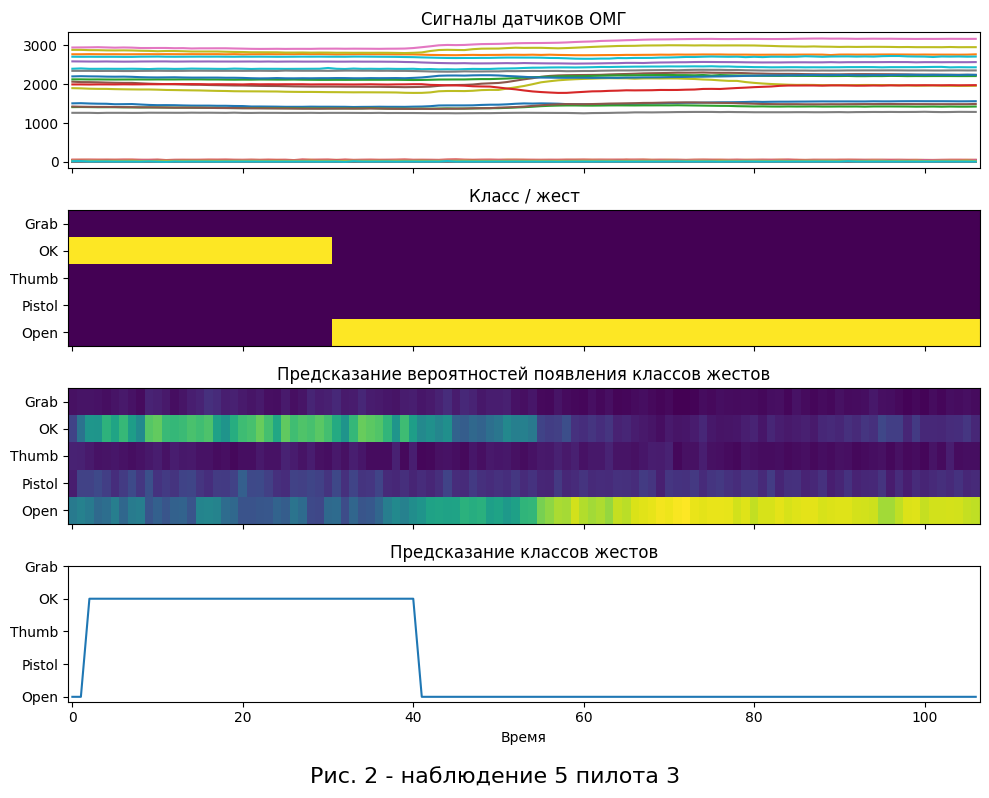

In [20]:
# Отображение предсказания моделью SimpleRNN
Pilot_id=3
y_pred_train_nn = mount['y_pred_train_nn']
y_pred_train_nn_mean = np.mean(x_trn_pred_dict[Pilot_id], axis=0)

figures.get_gesture_prediction_plot(
    Pilot_id=3, 
    i=5, 
    mounts=mounts, 
    y_pred_train_nn_mean=y_pred_train_nn_mean, 
    plot_counter=2
)

experiment.log_figure(figure_name='fig.8') # логгируем график

### Model architecture (LSTM)

In [21]:
_, n_timesteps, n_channels = X_train_nn.shape
output_units = np.mean(x_trn_pred_dict[3], axis=0).shape[-1]
print(f"input_shape = {(n_timesteps, n_channels)} | output_units = {output_units}")

input_channels = x = tf.keras.layers.Input(shape=(n_timesteps, n_channels))

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.LSTM(100, return_sequences=True)(x)
x = tf.keras.layers.LSTM(100, return_sequences=True)(x)
x = tf.keras.layers.LSTM(100, return_sequences=True)(x)
x = tf.keras.layers.LSTM(100, return_sequences=True, dropout=0.5)(x) 

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(units=output_units, activation='softmax')(x)

model_lstm = tf.keras.Model(
    inputs=input_channels,
    outputs=output,
    name="Model_LSTM"
)

# Отображение конфигурации модели
model_lstm.summary()

input_shape = (107, 50) | output_units = 5
Model: "Model_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 107, 50)]         0         
                                                                 
 batch_normalization (BatchN  (None, 107, 50)          200       
 ormalization)                                                   
                                                                 
 lstm (LSTM)                 (None, 107, 100)          60400     
                                                                 
 lstm_1 (LSTM)               (None, 107, 100)          80400     
                                                                 
 lstm_2 (LSTM)               (None, 107, 100)          80400     
                                                                 
 lstm_3 (LSTM)               (None, 107, 100)          80400     
             

### Model train (LSTM)

In [22]:
# Смотрим размерность тренировочных данных перед подачей в модель LSTM для пилота 1
mounts[3]['X_train_nn'].shape

(267, 107, 50)

In [23]:
# Смотрим размерность целевой переменной перед подачей в модель LSTM для пилота 1
mounts[3]['y_train_nn'].shape

(267, 107, 5)

In [24]:
# Смотрим размерность усредненной предсказанной целевой переменной перед подачей в модель LSTM для пилота 1
# чтобы сравнить с размерностью целевой переменной (проверяем правильность)
np.mean(x_trn_pred_dict[3], axis=0).shape

(267, 107, 5)

In [25]:
# Обучение модели LSTM на преобразованных данных y_train
for mount_name, mount in mounts.items():
    X_train_nn = mount['X_train_nn']
    y_pred_train_nn = np.mean(x_trn_pred_dict[mount_name], axis=0).argmax(axis=-1)
    y_pred_train_nn = tf.keras.utils.to_categorical(y_pred_train_nn)
    
    tf.keras.backend.clear_session()
    reset_random_seeds() # сброс и задание random seed
    m_lstm = tf.keras.models.clone_model(model_lstm)
    m_lstm.compile(
        loss="categorical_crossentropy",
        metrics=[f1],
        optimizer=tf.keras.optimizers.Adam(),
    )
       
    
    history = m_lstm.fit(
        X_train_nn,
        y_pred_train_nn,
        validation_split=0.2,  
        
        
        #
        # изменить кол-во эпох на 1500
        #
        epochs=50, #epochs=1500      
        verbose=1,
        callbacks=callbacks(lr=0.001, 
                            num_train=mount_name,
                            reduce_patience=10, 
                            stop_patience=200,
                            model_name='temp_best_lstm_')
    )

    mount['history'] = history
    
    mount['model_lstm'] = m_lstm

    # сохранение обученной модели в папке по пути PATH_FOR_MODEL
    m_lstm.save(os.path.join(PATH_FOR_MODEL, 'model_lstm_' + str(mount_name)), save_format='h5')
    
    # Расчеты ниже нужны, чтобы посмотреть результат предсказания для модели LSTM на X_train_nn
    y_pred_train_lstm = m_lstm.predict(X_train_nn)
    print(y_pred_train_lstm.shape)
    mount['y_pred_train_lstm'] = y_pred_train_lstm

# скрыть ход обучения модели
clear_output(wait=False)

{'web': 'https://www.comet.com/api/image/download?imageId=556fa6f99c0147e2804841fe7ff25e70&experimentKey=c91d260ad3bc408484bb872a827de41e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=556fa6f99c0147e2804841fe7ff25e70&experimentKey=c91d260ad3bc408484bb872a827de41e',
 'imageId': '556fa6f99c0147e2804841fe7ff25e70'}

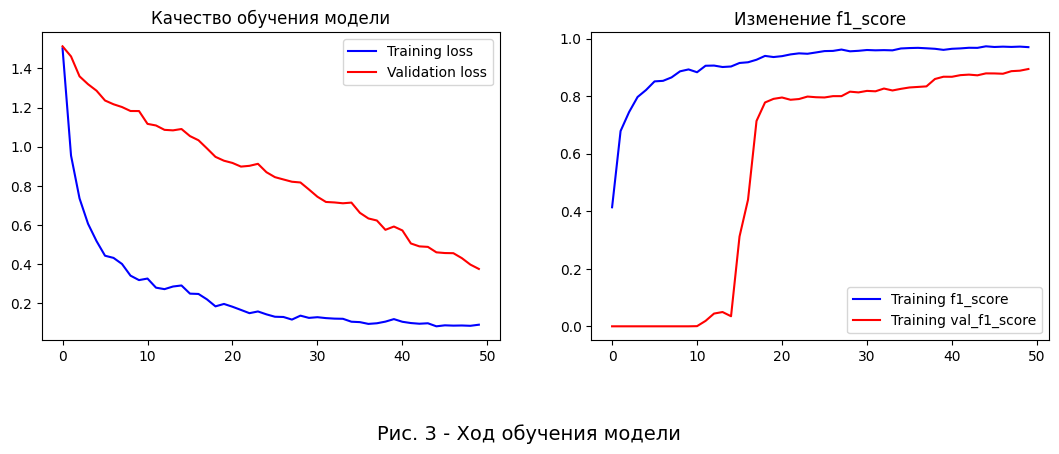

In [26]:
# Визуализируем ход обучения модели #1
figures.plot_history(mounts[1]['history'], plot_counter=3)
experiment.log_figure(figure_name='fig.9') # логгируем график

### Visualisation LSTM predictions

{'web': 'https://www.comet.com/api/image/download?imageId=257232dfe3ca4f5c93d36b95befc07f3&experimentKey=c91d260ad3bc408484bb872a827de41e',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=257232dfe3ca4f5c93d36b95befc07f3&experimentKey=c91d260ad3bc408484bb872a827de41e',
 'imageId': '257232dfe3ca4f5c93d36b95befc07f3'}

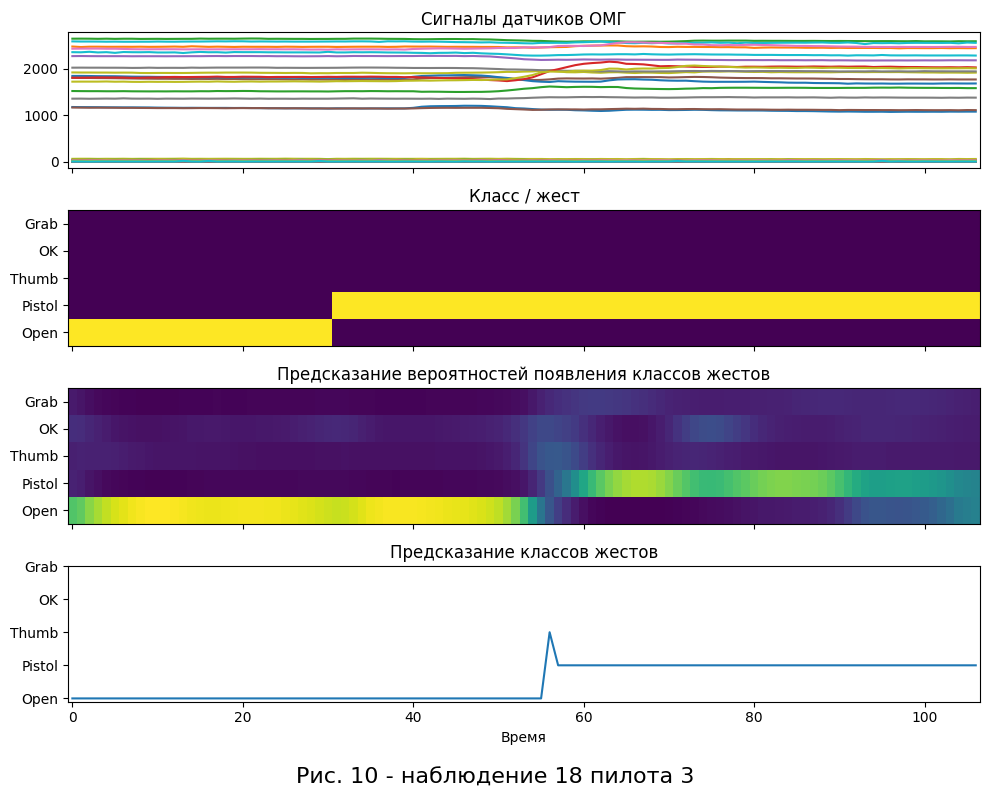

In [27]:
# Визуализируем предскание жеста моделью
Pilot_id=3 # номер пилота
y_pred_train_nn_mean = mount['y_pred_train_lstm']

figures.get_gesture_prediction_plot(
    Pilot_id=3, # номер пилота
    i=18, # номер наблюдения
    y_pred_train_nn_mean=y_pred_train_nn_mean, 
    mounts=mounts, # словарь
    plot_counter=10)

experiment.log_figure(figure_name='fig.10') # логгируем график

### Predict test & submit with LSTM model

In [28]:
for mount_name, mount in mounts.items():
    
    #Чтение модели LSTM из словаря (после обучения модели LSTM)
    m_lstm = mount['model_lstm']

    X_train_nn = mount['X_train_nn']
    X_test_dataset = mount['X_test_dataset']
    
    y_pred_test_lstm = []
    for i in range(len(X_test_dataset)):
        X_test_i = np.expand_dims(X_test_dataset[i], axis=0).swapaxes(1, 2).astype(np.float64)
        y_pred_test_lstm += [m_lstm.predict(X_test_i, verbose=0)]
        
    y_pred_test_lstm = [arr.argmax(axis=-1) for arr in y_pred_test_lstm]
    
    print(len(y_pred_test_lstm))
    assert len(y_pred_test_lstm) == y_test.query("subject_id == @mount_name")['sample'].nunique()
    
    mount['y_pred_test_lstm'] = y_pred_test_lstm

899
855
861


In [29]:
# Объединяем результаты предсказания в один лист

y_pred_test_res = []
for mount_name, mount in mounts.items():
    y_pred_test_res.extend(mount['y_pred_test_lstm'])
y_pred_test_res = np.concatenate(y_pred_test_res, axis=-1)[0]

# проверка соответствия размерности
assert y_pred_test_res.shape[0] == y_test.shape[0]

In [30]:
# Сохраняем результат предсказания модели в отдельный файл y_test_submit_rnn_LSTM.csv

y_test_submit = y_test[['subject_id-sample-timestep', 'class']]
y_test_submit['class'] = y_pred_test_res
y_test_submit.to_csv('./y_test_submit_rnn_LSTM.csv', index=False)

y_test_submit

,subject_id-sample-timestep,class
0,1-0-0,0
1,1-0-1,0
2,1-0-2,0
3,1-0-3,0
...,...,...
471606,3-860-177,0
471607,3-860-178,0
471608,3-860-179,0
471609,3-860-180,0


In [31]:
# Заканчиваем сессию логгирования эксперимента
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/alex1iv/gesture-classification/c91d260ad3bc408484bb872a827de41e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_f1 [1350]            : (0.08294926583766937, 0.9811264872550964)
COMET INFO:     batch_loss [1350]          : (0.02961798943579197, 2.3086395263671875)
COMET INFO:     epoch_duration [1350]      : (0.09299999999348074, 10.844000000011874)
COMET INFO:     f1 [1350]                  : (0.27226221561431885, 0.9733183979988098)
COMET INFO:     loss [1350]                : (0.03502797335386276, 1.7097389698028564)
COMET INFO:     lr [1350]                  : (0.0005314410664141178, 0.0010000000474974513)
COMET INFO:     val_f1 [1350]              : (0.0, 0.8944149017333984)
COMET INFO:     val_loss [1350]            : (0.0534

In [32]:
# отображаем результат обучения
experiment.display()

### Обсуждение результата

Как было показано выше, работа над моделью состояла из двух основных этапов:
- получение на данных X_train разметки y_train, соответствующей моменту совершения жеста;
- обучение итоговой модели на данных X_train и корректированной разметки y_train для последующего предикта на тестовых данных.  

Качество обучения итоговой модели оценивалось по score на Leaderboard, как основному критерию. Предварительно рассматривались результаты предсказания обученной модели для данных X_train.  

За основу итоговой модели (для предикта тестовых данных) была взята нейронная сеть с четырьмя слоями LSTM библиотеки Keras. Для повышения качества обучения рассматривалось: изменение количества слоев LSTM, добавление/исключение слоев BatchNormalization, Dropout и Dense и вариация их параметров и др. Дополнительно использовались встроенные функции callbacks библиотеки Keras, а также варьировалась доля валидационной выборки при обучении модели.

В ноутбуке выше приведена итоговая архитектура модели LSTM, которая стабильно показывала результат, близкий к максимально возможному.  

В ходе выбора архитектуры модели нашей командой и сравнения с результатами score на Leaderboard других команд мы пришли к выводу, что для выбранного метода обучения существует некий порог точности предсказаний на представленных данных, который соответствует примерно score 0.7 на Leaderboard (score при предсказании разными моделями в основном попадал в интервал 0.65 - 0.69, а порог 0.7 так и не был преодолён).  

Сравнение результатов предсказаний наших лучших моделей показало, что они совпадают, в среднем, на 80%. При этом на определенном участке одна модель, к примеру, предсказывала 40 временных единиц, заполненных классом 4, а другая определяла на том же участке одну часть, заполненную классом 1, потом интервал, заполненный классом 4, потом еще интервал - снова класс 1. А на другом участке картина была обратная: вторая модель отработала стабильнее. Таким образом, следуя принципу временных причинно-следственных связей, мы не смогли в режиме реального времени выбрать, какая из тестируемых моделей на конкретном жесте отработала лучше. Такой вывод можно сделать только постфактум. Длина участка с расхождениями могла составить более 10 временных единиц, т.е. постобработка с "запаздыванием" на несколько временных единиц также не добавила бы определенности. Предполагается, что улучшение предсказания можно получить, усреднив предсказания вероятностей классов тремя оптимальными моделями LSTM.  


Основная задача первого этапа заключалась в обучении модели предсказывать классы (жесты) в текущий момент времени по показаниям датчиков и получать момент выполнения жеста (ступеньку на графике y_train) фиксируя момент изменения класса (получение на данных X_train скорректированной разметки y_train).  

Для определения классов нами были протестированы разные модели и архитектуры нейронных сетей библиотеки Keras. Сложная модель SRNN, например, c несколькими слоями SRNN, подстраивала предсказания классов под момент времени, 
соответствующий моменту подачи сигнала манипулятором. Поэтому такая модель давала ошибочные предсказания.

В качестве выборки для обучения других моделей подавались участки X_train двух типов: 
- включающие момент выполнения жеста, 
- участки, где жест оставался неизменным.
 
Однако, модели ошибочно предсказывали отсутствие изменения классов на участках обоих типов.

Поэтому для решения вышеописанной проблемы было решено использовать нейронную сеть SimpleRNN с простой архитектурой и обучать её на различных долях валидационной выборки (применение различных validation_split). Ошибки работы такой модели можно корректировать с помощью усреднения вероятностей предсказаний классов по рассматриваемым validation_split. Это позволит получить корректирующую разметку для последующего обучения более сложной модели (модели со слоями LSTM).

Также проводился анализ влияния корректировки разметки данных на качество предсказания, заключавшийся в следующем: 
- удаление "битых" данных из X_train второго пилота и отдельных выбросов в предсказании y_train; 
- приведение предсказания класса жеста к виду, установленному в протоколе: два класса жеста, разделенных "ступенькой"; 
- подстановка правильных классов в тех эпохах, где SimpleRNN ошиблась в классификации жестов. 

Однако, указанные преобразования не привели к повышению качества предсказаний итоговой модели LSTM. 

Дополнительно нужно отметить, что более 80% ошибок при классификации жестов моделью SimpleRNN заключалось в не распознавании отличия жеста "2" (сгиб большого пальца) от жеста "0" ("open"). Вероятно, показания датчиков этих двух жестов похожи. Поэтому рекомендуется изменить положения оптомиографических датчиков и провести повторный анализ.